In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
import textract

In [54]:
import os
import re
import tldextract
import json

x = []
texts = []
y = []
for root, dirs, files in os.walk("/Users/d062334/Downloads/output", topdown=False):
    for name in files:
        #print(name)
        if name != '.DS_Store' and name.endswith(".pdf"):
            try:
                metadata = json.load(open(os.path.join(root, name) + ".json"))
                texts.append(textract.process(os.path.join(root, name)).decode("utf-8"))
                y.append(re.sub(r".*/","", root))
                x.append({
                    "tld-url": '.'.join(tldextract.extract(metadata["url"])[:2]),
                    "tld-parent-url": '.'.join(tldextract.extract(metadata["parent_url"])[:2])
                })
            except Exception as e:
                print(str(e))
                pass

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
'charmap' codec can't decode byte 0x9d in position 559: character maps to <undefined>
'charmap' codec can't decode byte 0x9d in position 559: character maps to <undefined>
[Errno 2] No such file or directory: '/Users/d062334/Downloads/output/Paper/httpscs.stanford.edupeoplechrismrepaperspaper49.Ngo.pdf.json'
Expecting value: line 1 column 1 (char 0)
'charmap' codec can't decode byte 0x9d in position 23387: character maps to <undefined>
Expecting value: line 1 column 1 (char 0)
'charmap' codec can't decode byte 0x9d in position 2209: character maps to <undefined>
[Errno 2] No such file or directory: '/Users/d062334/Downloads/output/Paper/httpscs.stanford.edupeoplechrismrepaperstuffyvldb11.pdf.json'
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)

In [25]:
import nltk
import math
from sklearn.base import BaseEstimator
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np

import re
from collections import Counter
def words(text): return re.findall(r'\w+', text.lower())

class LinguisticVectorizer(BaseEstimator):

    def get_feature_names(self):
        return np.array(
            ['text_length',
             'number_of_paragraphs',
             'average_sent_length',
             'average_word_length',
             'number_of_nouns',
             'number_of_adjectives',
             'number_of_verbs',
             'type_token_relation',
             'hapaxes_index',
             'action_index',
             'number_of_question_marks',
             'number_of_exclamations',
             'number_of_percentages',
             'number_of_currency_symbols',
             'number_of_paragraph_symbols',
             'content_fraction',
             'number_of_cappsed_words',
             'number_of_first_person_pronouns']
        )

    def fit(self, documents, y=None):
        return self
    
    def __filter(self, string):
        return [w for w in word_tokenize(string) if w.isalpha()]
    
    def _get_text_length(self, string):
        tokens = self.__filter(string)
        return len(tokens)
    
    def _get_number_of_paragraphs(self, string):
        return round(string.count('\n') / 2)
    
    def _get_average_sent_length(self, string):
        tokens = self.__filter(string)
        if len(sent_tokenize(string)) is 0:
            return len(tokens)
        return len(tokens) / len(sent_tokenize(string))
    
    def _get_average_word_length(self, string):
        tokens = self.__filter(string)
        word_length_list = []
        for word in tokens:
            word_length_list.append(len(word))
        return np.average(word_length_list)

    def _get_number_of_nouns(self, string):
        nouns = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['NN', 'NNS', 'NNP', 'NNPS']]
        return len(nouns) / self._get_text_length(string)
    
    def _get_number_of_adjectives(self, string):
        adjectives = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['JJ', 'JJR', 'JJS']]
        return len(adjectives) / self._get_text_length(string)
   
    def _get_number_of_verbs(self, string):
        verbs = [a[0] for a in pos_tag(self.__filter(string)) if a[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]
        return len(verbs) / self._get_text_length(string)
    
    def _get_ttr(self, string):
        tokens = self.__filter(string)
        if len(tokens) is 0:
            return 0
        return len(set(tokens)) / len(tokens)

    def _get_aq(self, string):
        adjectives = self._get_number_of_adjectives(string)
        verbs = self._get_number_of_verbs(string)
        if adjectives is 0:
            return verbs
        return verbs / adjectives

    def _get_naq(self, string):
        adjectives = self._get_number_of_adjectives(string)
        verbs = self._get_number_of_verbs(string)
        if adjectives is 0 and verbs is 0:
            return 0
        return verbs / (adjectives + verbs)

    def _get_hl(self, string):
        words = self.__filter(string)
        fdist = nltk.FreqDist(words)
        hapaxes = fdist.hapaxes()
        if len(words) is 0:
            return len(hapaxes)
        return len(hapaxes) / len(words)
    
    def _get_number_of_spelling_mistakes(self, string):
        text_vocub = set(w.lower() for w in word_tokenize(string) if w.isalpha())
        text_dict  = set(w.lower() for w in dictionary)
        return len(text_vocub - text_dict) / self._get_text_length(string)
    
    def _get_number_of_currency_symbols(self, string):
        currencies = ["£","€","$","¥","¢","₩"]
        sum = 0
        for currency in currencies:
            sum += self._get_number_of_symbol(string, currency)
        return sum / self._get_text_length(string)
    
    def _get_number_of_symbol(self, string, symbol):
        return string.count(symbol) / self._get_text_length(string)
    
    def _get_content_fraction(self, string):
        tokens = self.__filter(string)
        content = [w for w in tokens if w.lower() not in stopwords.words('english')]
        if len(tokens) is 0:
            return 0
        return len(content) / len(tokens)
    
    def _get_number_of_cappsed_words(self, string):
        tokens = self.__filter(string)
        return np.sum([t.isupper() for t in tokens if len(t) > 2]) / self._get_text_length(string)
    
    def _get_number_of_first_person_pronouns(self, string):
        tokens = word_tokenize(string)
        pronouns = ["i","me","my", "mine", "myself","we", "our", "ours", "ourself"]
        sum = 0
        mode = 0
        for word in tokens:
            if word == "``":
                mode = mode + 1
            elif word == "''":
                mode = mode - 1
            
            if mode <= 0 and word.lower() in '\t'.join(pronouns):
                sum += 1
        return sum / len(tokens)

    def transform(self, documents):
        text_length = [self._get_text_length(d) for d in documents]
        number_of_paragraphs = [self._get_number_of_paragraphs(d) for d in documents]
        print("---1")
        average_length_of_sent = [self._get_average_sent_length(d) for d in documents]
        average_word_length = [self._get_average_word_length(d) for d in documents]
        print("---2")
        number_of_nouns = [self._get_number_of_nouns(d) for d in documents]
        number_of_adjectives = [self._get_number_of_adjectives(d) for d in documents]
        number_of_verbs = [self._get_number_of_verbs(d) for d in documents]
        print("---3")
        type_token_relation = [self._get_ttr(d) for d in documents]
        hapaxes_index = [self._get_hl(d) for d in documents]
        action_index = [self._get_naq(d) for d in documents]
        print("---4")
        number_of_question_marks = [self._get_number_of_symbol(d, "?") for d in documents]
        number_of_exclamations = [self._get_number_of_symbol(d, "!") for d in documents]
        number_of_percentages = [self._get_number_of_symbol(d, "%") for d in documents]
        number_of_currency_symbols = [self._get_number_of_currency_symbols(d) for d in documents]
        number_of_paragraph_symbols = [self._get_number_of_symbol(d, "§") for d in documents]
        content_fraction = [self._get_content_fraction(d) for d in documents]
        number_of_cappsed_words = [self._get_number_of_cappsed_words(d) for d in documents]
        number_of_first_person_pronouns = [self._get_number_of_first_person_pronouns(d) for d in documents]
        
        result = np.array(
            [text_length,
             number_of_paragraphs,
             average_length_of_sent,
             average_word_length,
             number_of_nouns,
             number_of_adjectives,
             number_of_verbs,
             type_token_relation,
             hapaxes_index,
             action_index,
             number_of_question_marks,
             number_of_exclamations,
             number_of_percentages,
             number_of_currency_symbols,
             number_of_paragraph_symbols,
             content_fraction,
             number_of_cappsed_words,
             number_of_first_person_pronouns]
        ).T

        return result

In [4]:
ling = LinguisticVectorizer();

x_ling = ling.fit(texts).transform(texts)

---1
---2
---3
---4


In [36]:
import pandas as pd
url_features = pd.get_dummies(pd.DataFrame(x))
url_features.head()

,tld-parent-url_ai.stanford,tld-parent-url_bingschool.stanford,tld-parent-url_boole.stanford,tld-parent-url_ccrma.stanford,tld-parent-url_cepa.stanford,tld-parent-url_crypto.stanford,tld-parent-url_cs.stanford,tld-parent-url_cs242.stanford,tld-parent-url_cvgl.stanford,tld-parent-url_giving.stanford,...,tld-url_nlp.stanford,tld-url_theory.stanford,tld-url_ucomm.stanford,tld-url_uit.stanford,tld-url_urology.stanford,tld-url_vision.stanford,tld-url_web.stanford,tld-url_www-cs-students.stanford,tld-url_www.scs.stanford,tld-url_yuba.stanford
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [39]:
ling_features = pd.DataFrame(x_ling, columns=LinguisticVectorizer().get_feature_names())
ling_features.head()

,text_length,number_of_paragraphs,average_sent_length,average_word_length,number_of_nouns,number_of_adjectives,number_of_verbs,type_token_relation,hapaxes_index,action_index,number_of_question_marks,number_of_exclamations,number_of_percentages,number_of_currency_symbols,number_of_paragraph_symbols,content_fraction,number_of_cappsed_words,number_of_first_person_pronouns
0,7816.0,506.0,12.729642,5.626663,0.430015,0.109519,0.140609,0.253454,0.139841,0.562148,0.000128,0.0,0.002431,1.636933e-08,0.0,0.671571,0.010875,0.023471
1,4936.0,574.0,15.234568,5.322123,0.447934,0.111629,0.123177,0.278566,0.164303,0.524590,0.002836,0.0,0.026337,1.272364e-06,0.0,0.670989,0.009927,0.032409
2,421.0,37.0,21.050000,5.320665,0.380048,0.111639,0.118765,0.565321,0.410926,0.515464,0.000000,0.0,0.000000,5.642035e-06,0.0,0.577197,0.009501,0.022642
3,2293.0,191.0,16.262411,5.341038,0.509376,0.085041,0.098125,0.323594,0.217619,0.535714,0.000436,0.0,0.012647,0.000000e+00,0.0,0.675534,0.030528,0.025617
4,3901.0,317.0,15.003846,5.724430,0.451679,0.104332,0.125609,0.288900,0.148167,0.546265,0.001025,0.0,0.007947,2.628501e-07,0.0,0.667777,0.006921,0.021939


In [41]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-300")  # download the model and return as object ready for use

In [42]:
import nltk
from nltk.tokenize import wordpunct_tokenize 

In [43]:
def getVectorsOf(model, text):
    vectors = []
    for token in wordpunct_tokenize(text):
        try:
            vectors.append(model[token])
        except:
            pass
    return vectors

In [44]:
import numpy as np

In [45]:
w2v_features = []
for text in texts:
    w2v_features.append(np.array(getVectorsOf(model, text)).mean(axis=0))

In [49]:
w2v_features = pd.DataFrame(w2v_features).add_prefix("w2v_")

In [51]:
features = pd.concat([url_features, ling_features, w2v_features], axis=1)

In [52]:
rf = RandomForestClassifier()

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, y, test_size=0.2)

In [65]:
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
predictions = rf.predict(X_test)

In [68]:
predictions

array(['Journal', 'Grading', 'Grading', 'CV', 'Paper', 'CV', 'Grading',
       'Administration', 'Administration', 'Grading', 'CV', 'Grading',
       'CV', 'CV', 'Paper', 'Paper', 'Paper', 'Presentation', 'Grading',
       'Award', 'Award', 'Grading', 'Paper', 'Paper', 'Award'],
      dtype='<U14')

In [69]:
sklearn.metrics.accuracy_score(Y_test, predictions)

0.72

In [76]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 2 0]
 [0 1 1 0 7 0 0 0]
 [0 0 1 0 0 1 2 0]
 [0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1]]


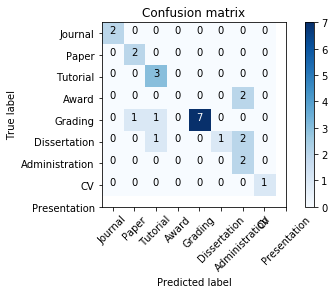

In [77]:
cnf_matrix = sklearn.metrics.confusion_matrix(Y_test, predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Journal", "Paper","Tutorial", "Award", "Grading", "Dissertation", "Administration", "CV", "Presentation"],
                      title='Confusion matrix')


In [71]:
y

['Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Journal',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Paper',
 'Tutorial',
 'Tutorial',
 'Tutorial',
 'Tutorial',
 'Tutorial',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Award',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Grading',
 'Dissertation',
 'Disserta

In [79]:
import pickle
output = open('document_type_classifier.pkl', 'wb')
pickle.dump(rf, output)
output.close()

In [82]:
output = open('url_features.pkl', 'wb')
pickle.dump(url_features.columns, output)
output.close()